# Stat222 HW3

Seokjun Choi

*All code blocks are Python scripts.*
*Used Python version is 3.10.5 for Windows, 64 bits.*

## Question 1

*Python script:*
- Q1: https://github.com/letsjdosth/bnp/blob/main/hw3_q1.py
- dependencies
    - latest versions of `numpy`, `scipy`, `matplotlib` for python 3 
    - ./hwk3-data.txt
    - https://github.com/letsjdosth/bnp/blob/main/pyBayes/MCMC_Core.py
    - https://github.com/letsjdosth/bnp/blob/main/pyBayes/rv_gen_gamma.py

### Implementation (Question 1-(1))

Using the full-conditional distributions for all variables $(\theta_1,...,\theta_n,\phi,\mu,\tau^2,\eta,\alpha)$ that I showed in my note, we can construct a gibbs sampler.
The class `Hw3Q1_MarginalSampler` is my implementation.
I define two additional functions, `posterior_predictive_density_estimator` and `prior_predictive_density_estimator`, for posterior and prior predictive draws.

In [1]:
from math import log, inf
from random import randint, seed, choices
import csv

import numpy as np
import scipy.stats as sp_stats
import matplotlib.pyplot as plt

from pyBayes.MCMC_Core import MCMC_Gibbs, MCMC_Diag
from pyBayes.rv_gen_gamma import Sampler_univariate_InvGamma

class Hw3Q1_MarginalSampler(MCMC_Gibbs):
    def __init__(self, initial, y_obs: list, hyper: tuple | None =None):
        #param
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        self.MC_sample = [initial]
        self.y = y_obs
        self.n = len(y_obs)

        self.inv_gamma_sampler_inst = Sampler_univariate_InvGamma()

        if hyper is None:
            self.hyper_a_phi = 0.01
            self.hyper_b_phi = 0.01
            self.hyper_a_mu = 0
            self.hyper_b_mu = 1
            self.hyper_a_tau2 = 0.01
            self.hyper_b_tau2 = 0.01
            self.hyper_a_alpha = 0.01
            self.hyper_b_alpha = 0.01
        else:
            self.hyper_a_phi, self.hyper_b_phi, self.hyper_a_mu, self.hyper_b_mu, self.hyper_a_tau2, self.hyper_b_tau2, self.hyper_a_alpha, self.hyper_b_alpha = hyper
    
    def sampler(self, **kwargs):
        last = self.MC_sample[-1]
        new = self.deep_copier(last)
        #update new
        new = self.full_conditional_sampler_theta(new)
        new = self.full_conditional_sampler_phi(new)
        new = self.full_conditional_sampler_mu(new)
        new = self.full_conditional_sampler_tau2(new)
        new = self.full_conditional_sampler_eta(new)
        new = self.full_conditional_sampler_alpha(new)
        self.MC_sample.append(new)
    
    def theta_counter(self, theta_vec:list):
        "n_star, theta_stars, n_js, first-class func"
        distinguished_theta_num_n_star = 0
        distinguished_theta_stars = []
        distinguished_theta_star_count = []
        sorted_thetas = sorted(theta_vec)
        last_theta = inf #dangerous
        for theta in sorted_thetas:
            # tol = 1e-6
            if last_theta != theta:
                distinguished_theta_num_n_star += 1
                distinguished_theta_stars.append(theta)
                distinguished_theta_star_count.append(1)
                last_theta = theta
            else:
                distinguished_theta_star_count[-1] += 1
        return distinguished_theta_num_n_star, distinguished_theta_stars, distinguished_theta_star_count
        

    def full_conditional_sampler_theta(self, last_param):
        #param
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        phi = last_param[1]
        mu = last_param[2]
        tau2 = last_param[3]
        alpha = last_param[5]
        
        #update new
        new_sample = self.deep_copier(last_param)
        new_theta = new_sample[0] #pointer
        for i, y in enumerate(self.y):
            new_theta_i = None
            
            unif_sample = sp_stats.uniform.rvs()
            q0_weight_for_g0 = sp_stats.norm.pdf(y, mu, (tau2+phi)**0.5) * alpha
            _, theta_stars, n_j_stars = self.theta_counter(new_theta[:i]+new_theta[i+1:])
            prev_theta_weights = [nj * sp_stats.norm.pdf(y, t, phi**0.5) for t,nj in zip(theta_stars, n_j_stars)]
            normalizing_const_of_weight = q0_weight_for_g0 + sum(prev_theta_weights)

            if unif_sample < q0_weight_for_g0/normalizing_const_of_weight:
                post_g0_var = 1/(1/phi + 1/tau2)
                post_g0_mean = (y/phi + mu/tau2)*post_g0_var
                new_theta_i = sp_stats.norm.rvs(post_g0_mean, post_g0_var**0.5)
            else:
                new_theta_i = choices(theta_stars, weights=prev_theta_weights)[0]
            new_theta[i] = new_theta_i
            # new_sample[0] = new_theta #it is not needed
        return new_sample
    
    def full_conditional_sampler_phi(self, last_param):
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        new_sample = [x for x in last_param]
        thetas = last_param[0]
        shape = self.hyper_a_phi + self.n/2
        rate = self.hyper_b_phi
        for y_i, t_i in zip(self.y, thetas):
            rate += (0.5 * (y_i-t_i)**2)
        new_phi = self.inv_gamma_sampler_inst.sampler(shape, rate)

        # new_phi = 1 #true
        new_sample[1] = new_phi
        return new_sample
    
    def full_conditional_sampler_mu(self, last_param):
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        tau2 = last_param[3]
        
        new_sample = [x for x in last_param]
        
        n_star, theta_stars, _ = self.theta_counter(new_sample[0])
        
        post_var = 1/(1/self.hyper_b_mu + n_star/tau2)
        post_mean = (self.hyper_a_mu/self.hyper_b_mu + sum(theta_stars)/tau2)*post_var
        new_mu = sp_stats.norm.rvs(post_mean, post_var**0.5)
        
        # new_mu = 0.05 #true
        new_sample[2] = new_mu
        return new_sample
    
    def full_conditional_sampler_tau2(self, last_param):
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        mu = last_param[2]
        
        new_sample = [x for x in last_param]
        n_star, theta_stars, _ = self.theta_counter(new_sample[0])

        shape = self.hyper_a_tau2 + n_star/2
        rate = self.hyper_b_tau2
        for t_i in theta_stars:
            rate += (0.5 * (t_i-mu)**2)
        new_tau2 = self.inv_gamma_sampler_inst.sampler(shape, rate)
        new_sample[3] = new_tau2
        return new_sample
    
    def full_conditional_sampler_eta(self, last_param):
        #  0                      1    2   3     4    5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        alpha = last_param[5]
        
        new_sample = [x for x in last_param]
        new_eta = sp_stats.beta.rvs(alpha+1, self.n)
        new_sample[4] = new_eta
        return new_sample
    
    def full_conditional_sampler_alpha(self, last_param):
        #  0                      1    2   3     4     5
        # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
        eta = last_param[4]

        new_sample = [x for x in last_param]
        n_star, _, _ = self.theta_counter(new_sample[0])

        shape1 = self.hyper_a_alpha + n_star
        shape2 = shape1 - 1
        rate = self.hyper_b_alpha - log(eta)
        mixture1_weight = shape2 / (self.n*rate + shape2)

        new_alpha = None
        unif_sample = sp_stats.uniform.rvs()
        if unif_sample < mixture1_weight:
            new_alpha = sp_stats.gamma.rvs(a=shape1, scale=1/rate)
        else:
            new_alpha = sp_stats.gamma.rvs(a=shape2, scale=1/rate)

        new_sample[5] = new_alpha
        return new_sample
    
def posterior_predictive_density_estimator(grid, posterior_samples, n_sample_size):
    #  0                      1    2   3     4     5
    # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
    # 0       1            2
    #(n_star, theta_stars, n_js)
    temp_gibbs_inst = Hw3Q1_MarginalSampler([None], [None], None)
    prob_vec_at_grid = []
    for y in grid:
        prob_vec_at_y = []
        for s in posterior_samples:
            unif_sample = sp_stats.uniform.rvs()
            post_g0_weight = s[5]/(s[5]+n_sample_size)
            if unif_sample < post_g0_weight:
                theta_0 = sp_stats.norm.rvs(s[2], s[3]**0.5)
            else:
                _, theta_stars, n_js = temp_gibbs_inst.theta_counter(s[0])
                theta_0 = choices(theta_stars, weights=n_js)
            # print(theta_0, s[1]) # for debug
            post_prob_y0 = sp_stats.norm.pdf(y, theta_0, s[1]**0.5)
            prob_vec_at_y.append(post_prob_y0)
        expected_at_y = sum(prob_vec_at_y)/len(prob_vec_at_y)
        prob_vec_at_grid.append(expected_at_y)
    return prob_vec_at_grid

def prior_predictive_density_estimator(grid, hyper, prior_simul_size=300):
    # hyperparameters
    #  0            1            2           3           4             5             6              7
    # [hyper_a_phi, hyper_b_phi, hyper_a_mu, hyper_b_mu, hyper_a_tau2, hyper_b_tau2, hyper_a_alpha, hyper_b_alpha]
    #  0                      1    2   3     4     5
    # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
    # 0       1            2
    #(n_star, theta_stars, n_js)
    prior_samples = []
    for _ in range(prior_simul_size):
        invgamma_sampler_inst = Sampler_univariate_InvGamma()
        phi_prior_sample = invgamma_sampler_inst.sampler(hyper[0], hyper[1])
        mu_prior_sample = sp_stats.norm.rvs(hyper[2], hyper[3]**0.5)
        tau2_prior_sample = invgamma_sampler_inst.sampler(hyper[4], hyper[5])
        theta_prior_sample = None
        alpha_prior_sample = sp_stats.gamma.rvs(a=hyper[6], scale=1/hyper[7])
        prior_samples.append([[theta_prior_sample], phi_prior_sample, mu_prior_sample, tau2_prior_sample, None, alpha_prior_sample])

    prob_vec_at_grid = []
    for y in grid:
        prob_vec_at_y = []
        for s in prior_samples:
            theta_0 = sp_stats.norm.rvs(s[2], s[3]**0.5)
            prior_prob_y0 = sp_stats.norm.pdf(y, theta_0, s[1]**0.5)
            # print(s[2], s[3]**0.5, theta_0, y, prior_prob_y0) #for debug
            prob_vec_at_y.append(prior_prob_y0)
        expected_at_y = sum(prob_vec_at_y)/len(prob_vec_at_y)
        prob_vec_at_grid.append(expected_at_y)
    return prob_vec_at_grid

def sample_reader_from_csv_HW3Q1(filename):
    #  0                      1    2   3     4     5
    # [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
    with open(filename+".csv", "r", newline="") as csv_f:
        csv_reader = csv.reader(csv_f)
        MC_sample = []
        for row in csv_reader:
            theta = [float(x) for x in row[0][1:-1].split(',')]
            s = [theta, float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5])]
            MC_sample.append(s)
    return MC_sample           


## Prior sensitivity analysis (question 1-(2) and 1-(3)) 

For the prior sensitivity analysis, I consider eight sets of hyper-parameters.
Note that `set01` to `set04` correspond to the directions of question 1-(3).

|         | <div style="width:50px"></div> $\phi_a$ | <div style="width:50px"></div> $\phi_b$ | <div style="width:50px"></div> $\mu_a$ | <div style="width:50px"></div> $\mu_b$ | <div style="width:50px"></div> $\tau^2_a$ | <div style="width:50px"></div> $\tau^2_b$ | <div style="width:50px"></div> $\alpha_a$ | <div style="width:50px"></div> $\alpha_b$ |  <div style="width:220px"></div> |
| :------ | :--:     | :--:     | :--:    | :--:    | :--:       |  :--:      | :--:       | :--:       | :-------------------------- |  
| set1    | 0.01     | 0.01     |  0      |   1     | 0.01       |  0.01      | 0.01       | 0.01       | less informative            |
| set2    |    1     | 0.01     |  0      |   1     | 0.01       |  0.01      | 0.01       | 0.01       | inflated phi                |
| set3    | 0.01     | 0.01     |  0      |   1     | 1          |  0.01      | 0.01       | 0.01       | inflated tau2               |
| set4    | 0.01     | 0.01     |  5      | 0.1     | 0.01       |  0.01      | 0.01       | 0.01       | wrong mean of mu            |
| set01   | 0.01     | 0.01     |  0      |   1     | 0.01       |  0.01      | 2          |   15       | alpha with E(n*)=1          |
| set02   | 0.01     | 0.01     |  0      |   1     | 0.01       |  0.01      | 2          |    4       | alpha with E(n*)=3          |
| set03   | 0.01     | 0.01     |  0      |   1     | 0.01       |  0.01      | 2          |  0.9       | alpha with E(n*)=10         |
| set04   | 0.01     | 0.01     |  0      |   1     | 0.01       |  0.01      | 2          |  0.1       | alpha with E(n*)=48         |

In [ ]:
data = []
with open("data/hwk3-data.txt", "r", newline="\n") as f:
    for line in f:
        data.append(float(line))
# print(data[:20])
print(len(data)) #250
# plt.hist(data, bins=50)
# plt.show()

seed(20230528)
np.random.seed(20230528)

# hyperparameters
#  0            1            2           3           4             5             6              7
# [hyper_a_phi, hyper_b_phi, hyper_a_mu, hyper_b_mu, hyper_a_tau2, hyper_b_tau2, hyper_a_alpha, hyper_b_alpha]
hyperparam_set1 = [0.01, 0.01, 0, 1, 0.01, 0.01, 0.01, 0.01] #less informative
hyperparam_set2 = [1, 0.01, 0, 1, 0.01, 0.01, 0.01, 0.01] #inflated phi
hyperparam_set3 = [0.01, 0.01, 0, 1, 1, 0.01, 0.01, 0.01] #inflated tau2
hyperparam_set4 = [0.01, 0.01, 5, 0.1, 0.01, 0.01, 0.01, 0.01] #wrong mean of mu

hyperparam_set01 = [0.01, 0.01, 0, 1, 0.01, 0.01, 2, 15] #alpha with E(n*)=1
hyperparam_set02 = [0.01, 0.01, 0, 1, 0.01, 0.01, 2, 4] #alpha with E(n*)=3
hyperparam_set03 = [0.01, 0.01, 0, 1, 0.01, 0.01, 2, 0.9] #alpha with E(n*)=10
hyperparam_set04 = [0.01, 0.01, 0, 1, 0.01, 0.01, 2, 0.1] #alpha with E(n*)=48

I ran 500 iterations for each setting and cut the first 200 samples as a burn-in period.
The number of iterations is too small for Markov chains to converge perfectly, but I think it is enough for the posterior predictive check.

You can find all traceplots or other related plots at https://github.com/letsjdosth/bnp/tree/main/hw3_q1_figures

Here, I will display

1. traceplot of $n^*$
2. histogram of $n^*$. In the histogram, the red horizontal solid line marks the mean, the dashed line indicates the median, and the red horizontal solid line indicates 95% credible interval.
3. quantile plot of $\theta_i, i=1,2,...,n$. the upper and lower limits of black line are 0.25th and 0.75th quantiles, and the red dot marks 0.5th quantile or median. For example, we can get cluster component information for $y_i$ using the median of $\theta_i$ indicated as red-dot. Note that the horizontal axis is $\theta_1, \theta_2,...,\theta_{250}$.
4. estimated posterior density function(blue), with true data generating process's(red), and data(orange, histogram)


### prior sensitivity analysis: set1
<table>
  <tr>
    <td> <img src="./hw3_q1_figures/hyperparam_set1/n_star_traceplot.png" width=300></td>
    <td> <img src="./hw3_q1_figures/hyperparam_set1/n_star_hist.png" width=300> </td>
   </tr> 
   <tr>
      <td><img src="./hw3_q1_figures/hyperparam_set1/theta_quant.png" width=300></td>
      <td><img src="./hw3_q1_figures/hyperparam_set1/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set2
<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set2/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set2/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set2/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set2/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set3
<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set3/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set3/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set3/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set3/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set4
<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set4/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set4/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set4/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set4/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set01

<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set01/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set01/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set01/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set01/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set02

<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set02/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set02/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set02/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set02/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set03

<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set03/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set03/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set03/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set03/est_density.png" width=300></td>
  </tr>
</table>

### prior sensitivity analysis: set04

<table>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set04/n_star_traceplot.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set04/n_star_hist.png" width=300></td>
  </tr>
  <tr>
    <td><img src="./hw3_q1_figures/hyperparam_set04/theta_quant.png" width=300></td>
    <td><img src="./hw3_q1_figures/hyperparam_set04/est_density.png" width=300></td>
  </tr>
</table>

By comparing the above 8 cases, we can observe 

- Hyperparameters can have a massive effect on fitted $\theta_i$ values.
- As a result, hyperparameters affect fitted $n^*$ a lot.
- However, the point-estimated posterior density curves are not very different for each case.

In conclusion, if our purpose is clustering, setting good hyperparameters related to the number of clusters and $\theta_i$ values are very important.
I prefer a setting yielding fewer fitted clusters for a clustering purpose, but generally speaking, it is up to each specific context of data analysis.
However, if our purpose is just a density estimation, setting very good hyperparameters seems relatively less critical.

## Run MCMC longer! (Question 1-(4) and (5))

Based on the prior sensitivity analysis results, I think the hyperparameter `set02` seems reasonable.
Let me run the chain longer, 6200 iteration, and cut the first 200 as a burn-in period.
I generated 6200 samples and saved them (6200 iterations of the Gibbs sampler take around one hour).
In this report, I will use the saved samples.

In [3]:
now_hyper = hyperparam_set02
#  0                      1    2   3     4    5
# [[theta_1,...,theta_n], phi, mu, tau2, eta, alpha]
#                     0     1    2    3   4    5
gibbs_iter_initial = [data, 0.6, 0.5, 10, 0.02, 0.5]

gibbs_inst = Hw3Q1_MarginalSampler(gibbs_iter_initial, data, hyper=now_hyper)
diag_inst = MCMC_Diag()

mcmc_run = False #if I set it True, this block generates new MCMC samples. If False, this block uses the saved samples.
if mcmc_run:
    gibbs_inst.generate_samples(6200, print_iter_cycle=50)
    MC_sample = gibbs_inst.MC_sample
    diag_inst.set_mc_samples_from_list(MC_sample)
    diag_inst.write_samples("hw3q1_MCMCsamples")
else:    
    MC_sample = sample_reader_from_csv_HW3Q1("hw3q1_MCMCsamples")
    print(len(MC_sample))
    diag_inst.set_mc_samples_from_list(MC_sample)

diag_inst.burnin(200)

diag_inst_theta = MCMC_Diag()
diag_inst_theta.set_mc_samples_from_list(diag_inst.get_specific_dim_samples(0))
diag_inst_theta.set_variable_names(["theta"+str(i+1) for i in range(len(diag_inst_theta.MC_sample[0]))])
diag_inst_other_params = MCMC_Diag()
diag_inst_other_params.set_mc_samples_from_list([x[1:] for x in diag_inst.MC_sample])
diag_inst_other_params.set_variable_names(["phi", "mu", "tau2", "eta", "alpha"])

n_star_vec = []
for t in diag_inst_theta.MC_sample:
    n_star, theta_stars, n_js = gibbs_inst.theta_counter(t)
    n_star_vec.append([n_star])

diag_inst_n_star = MCMC_Diag()
diag_inst_n_star.set_mc_samples_from_list(n_star_vec)
diag_inst_n_star.set_variable_names(["n_star"])

6200


I display the traceplot for the first 20 $\theta_i$s, $i=1,2,...,20$ below.

After that, I put quantile plot of $\theta_i, i=1,2,...,n$, the same type plot as the third in the sensitivity analysis, which shows clustering information for each $\theta_i$.
The upper and lower limits of black line are 0.25th and 0.75th quantiles, and the red dot marks 0.5th quantile or median. For example, we can get cluster component information for $y_i$ using the median of $\theta_i$ indicated as red-dot. Again, the horizontal axis is $\theta_1, \theta_2,...,\theta_{250}$.

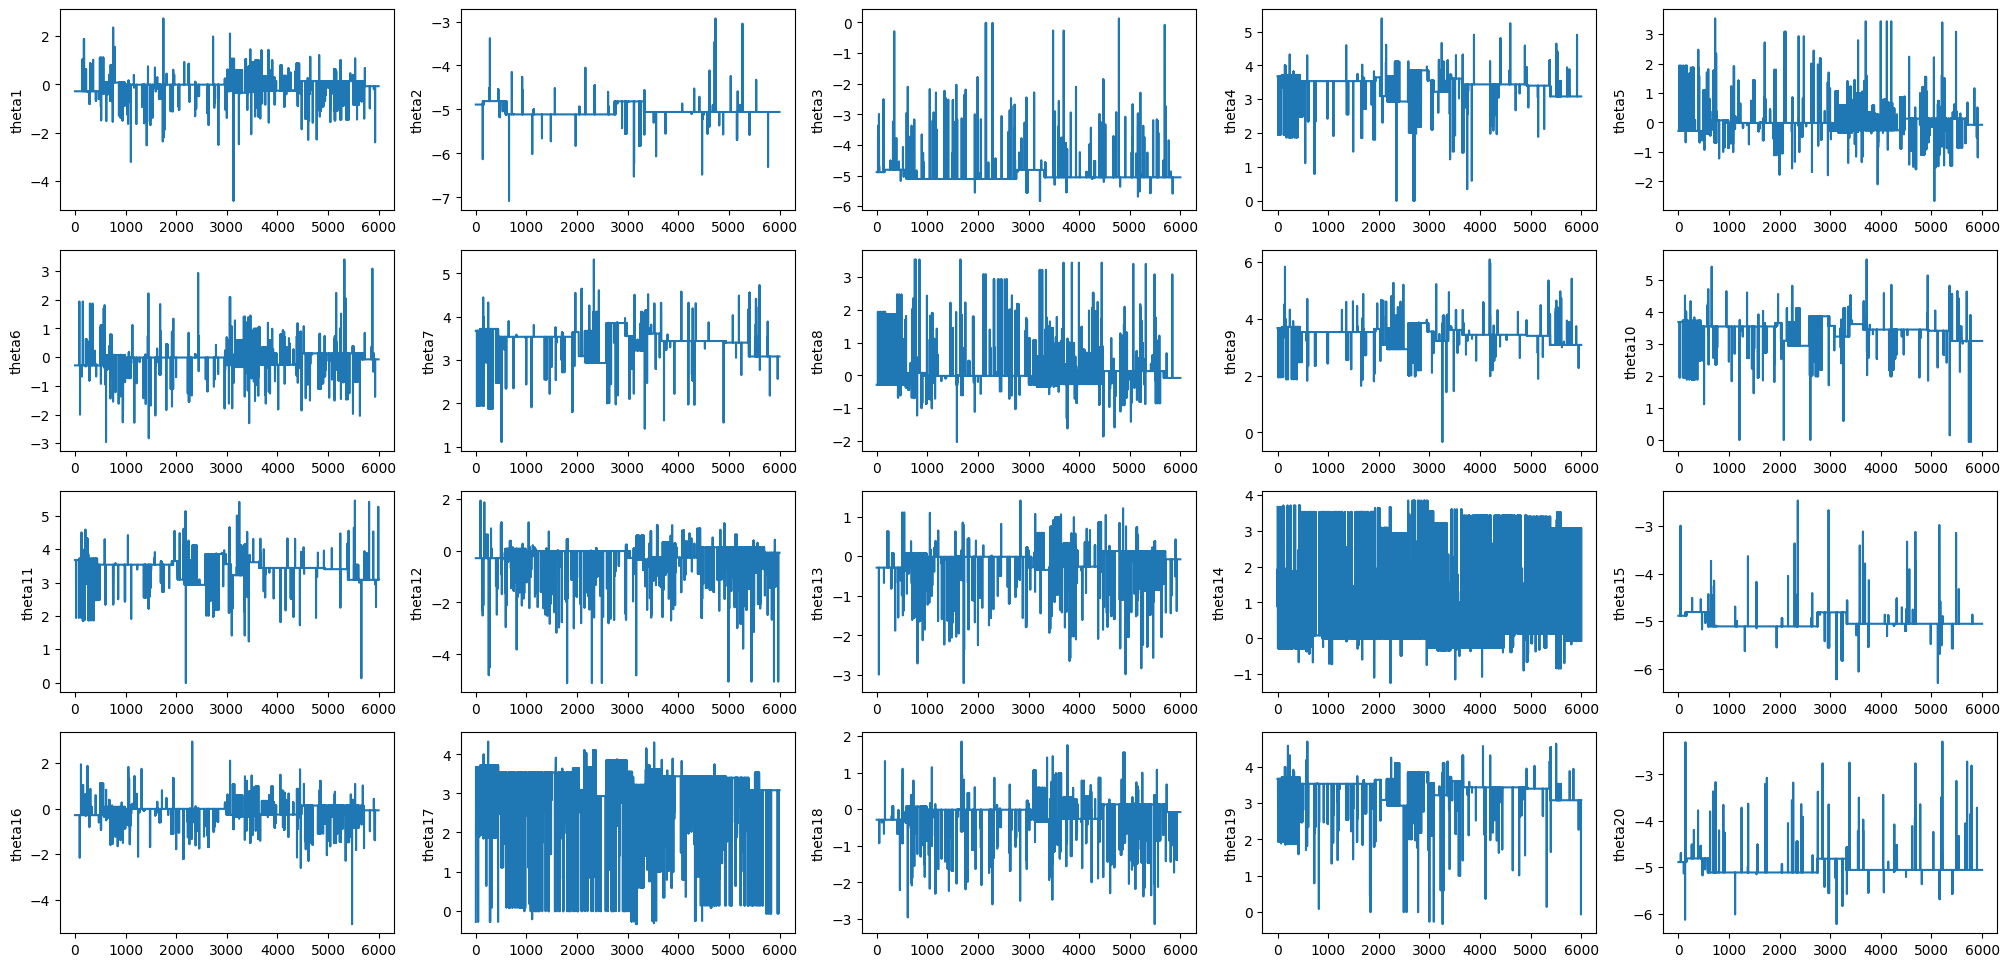

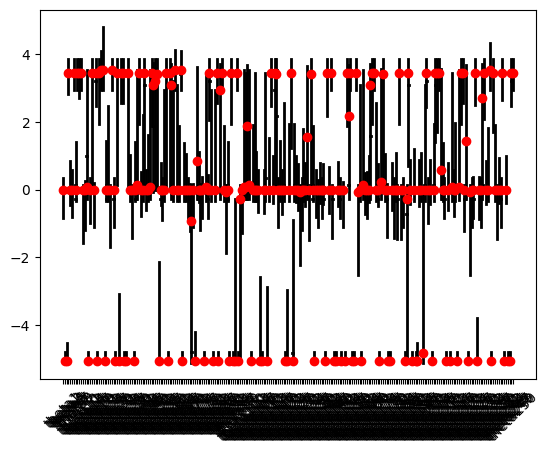

In [5]:
diag_inst_theta.show_traceplot((4,5), [x for x in range(20)])
diag_inst_theta.show_cred_interval_plot(mark="median")


Most of $\theta_i$s fall into three clusters near 3.5, 0, and -5, the mean values of true data generating process. 
We can observe additional clusters between the primary three, but their memberships are small.

Using predictive samples (by drawing $\theta_0$ based on other posterior parameters' sample values), we can evaluate similar clustering membership for new $y_0$, but let me skip displaying the result here.

Next is the traceplot and the histogram of $n^*$, the number of clusters.
In the histogram, the red horizontal solid line marks the mean, the dashed line indicates the median, and the red horizontal solid line indicates 95% credible interval.

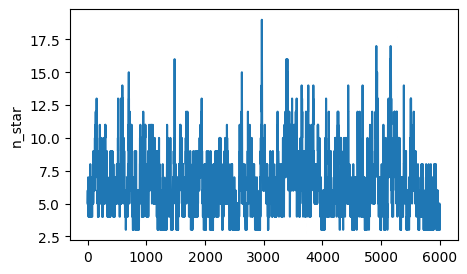

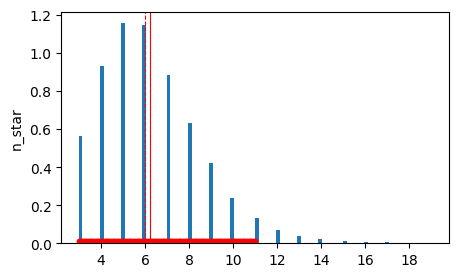

In [6]:
diag_inst_n_star.show_traceplot((1,1))
diag_inst_n_star.show_hist((1,1))

Our posterior distribution prefers 5 clusters!

Let me attach other parameters' traceplots, histograms, autocorrelation plots, and their summary table.
Again, in each histogram, the red horizontal solid line marks the mean, the dashed line indicates the median, and the red horizontal solid line indicates 95% credible interval.

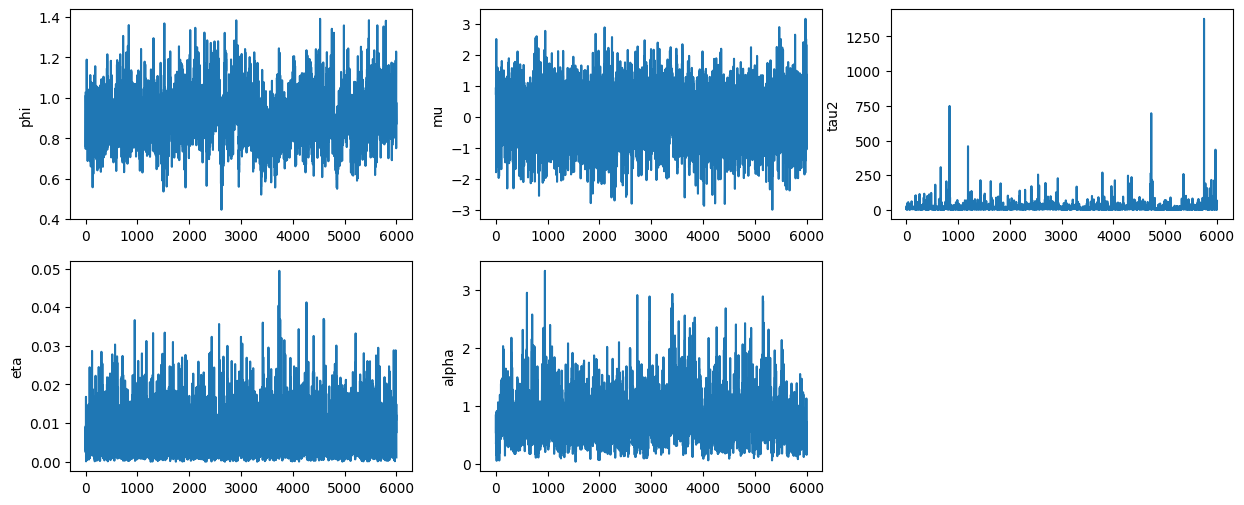

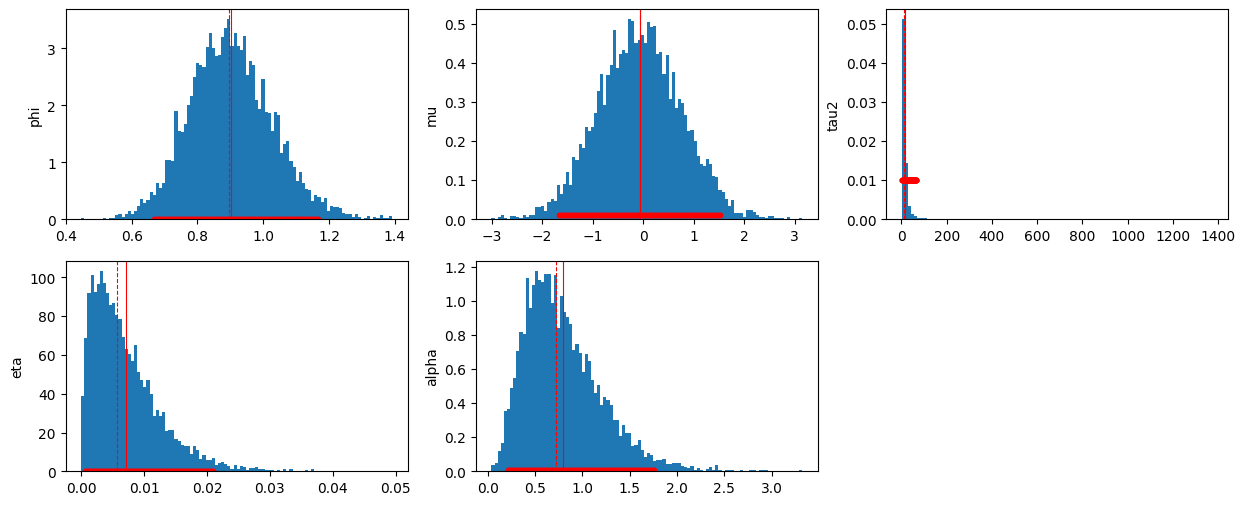

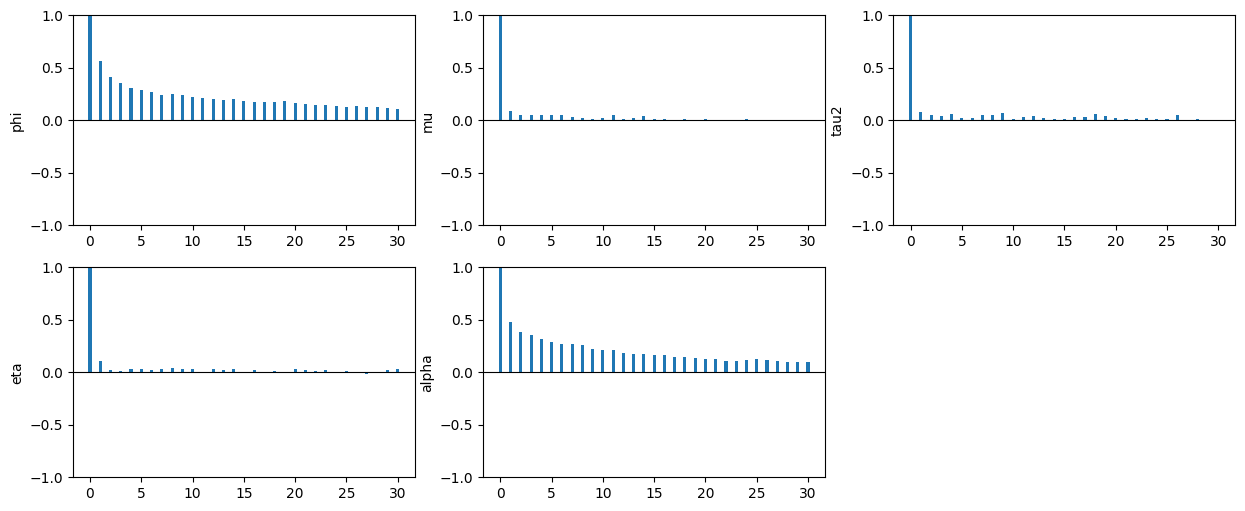

param 		 mean 	 var 	 95%CI
phi 		 0.90221 	 0.01582 	 [0.66886, 1.16711]
mu 		 -0.06417 	 0.68211 	 [-1.66448, 1.52943]
tau2 		 16.45679 	 947.01766 	 [3.46651, 65.2497]
eta 		 0.00713 	 3e-05 	 [0.00061, 0.02101]
alpha 		 0.79718 	 0.1669 	 [0.20985, 1.75644]


In [11]:
diag_inst_other_params.show_traceplot((2,3))
diag_inst_other_params.show_hist((2,3))
diag_inst_other_params.show_acf(30, (2,3))
diag_inst_other_params.print_summaries(5)

Everything seems good. There is no convergence issue.

Note that the ideal value for $\phi$ is $1$, $\mu$ is $0.05$ under our true data generating process. 
And these values are covered by the confidence interval.

As a final step, let me construct the density function estimation.

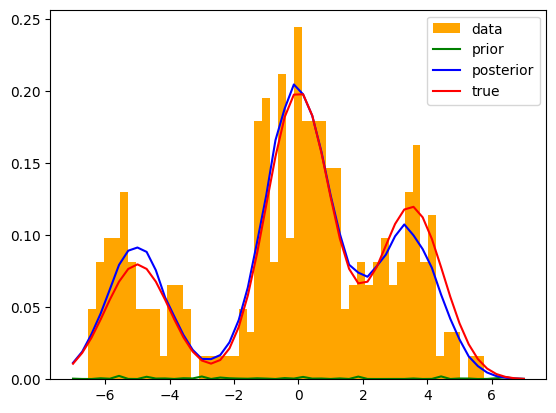

In [8]:
grid = np.linspace(-7, 7, 50).tolist()
density_pt_est_on_grid = posterior_predictive_density_estimator(grid, diag_inst.MC_sample, 250)
density_true_on_grid = [0.2*sp_stats.norm.pdf(x, -5, 1)+0.5*sp_stats.norm.pdf(x, 0, 1)+0.3*sp_stats.norm.pdf(x, 3.5, 1) for x in grid]
density_prior_pt_est_on_grid = prior_predictive_density_estimator(grid, now_hyper)


plt.hist(data, bins=50, density=True, color="orange", label='data')
plt.plot(grid, density_prior_pt_est_on_grid, color="green", label='prior')
plt.plot(grid, density_pt_est_on_grid, color="blue", label='posterior')
plt.plot(grid, density_true_on_grid, color="red", label='true')
plt.legend()
plt.show()


The posterior estimate is close to the true density.
Considering observations simultaneously, the posterior looks more reasonable, explaining the data well.

Let me note the prior predictive. Since the hyperparameter setting `set02` yields a very long-tail distribution for $\tau^2$ in priori,
the practical support of $\theta$ and $y$ in the prior is very wide. It is much broader than $[-7,7]$, the horizontal axis range.
That's why the prior predictive distribution function curve is near 0.
But, it is NOT precisely 0, so we could enjoy its 'full support.'

